# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 23.11.2019

Мягкий дедлайн: 8:00MSK 01.12.2019

Жесткий дедлайн: 23:59MSK 02.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [57]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [58]:
from sklearn.datasets import load_boston

In [59]:
boston = load_boston()

In [60]:
X = boston["data"]
y = boston["target"]

In [61]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [62]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.921053544597534

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [63]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    n = X.shape[0]
    cnts = np.zeros(n, dtype='int64')
    preds = np.zeros(n, dtype='float64')
    squares = np.zeros(n, dtype='float64')
    errs= np.zeros(n, dtype='float64')
    
    for i in range(num_runs):
        inds = np.zeros(n, dtype='bool')
        inds[np.random.choice(n, size=n)] = True
        out_inds = ~inds
        pred = regressor.fit(X[inds], y[inds]).predict(X[out_inds])
        preds[out_inds] += pred
        squares[out_inds] += pred**2
        errs[out_inds] += (pred - y[out_inds])**2
        cnts[out_inds] += 1
    
    used = cnts != 0
    bias = np.mean((preds[used] / cnts[used] - y[used]) ** 2)
    var = np.mean(squares[used] / cnts[used] - (preds[used] / cnts[used])**2) 
    error = np.mean(errs[used] / cnts[used])
    return bias, var, error
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

regs = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

for reg in regs:
    bias, var, err = compute_biase_variance(reg, X, y)
    mse = mean_squared_error(reg.fit(X_train, y_train).predict(X_test), y_test)
    print(reg.__class__.__name__ + 
          "\n\t Bias %6f \n\t Variance %6f \n\t Error %6f \n\t |Error - Bias - Variance| = %6f \n\n\t MSE %6f\n\t Ratio of MSE and error %6f \n\n\n" % (bias, var, err, np.abs(err - bias - var), mse, mse / err))

LinearRegression
	 Bias 23.789450 
	 Variance 0.600066 
	 Error 24.389516 
	 |Error - Bias - Variance| = 0.000000 

	 MSE 21.517444
	 Ratio of MSE and error 0.882242 



DecisionTreeRegressor
	 Bias 10.705138 
	 Variance 12.498607 
	 Error 23.203745 
	 |Error - Bias - Variance| = 0.000000 

	 MSE 11.669013
	 Ratio of MSE and error 0.502894 



RandomForestRegressor
	 Bias 11.047937 
	 Variance 2.756449 
	 Error 13.804386 
	 |Error - Bias - Variance| = 0.000000 

	 MSE 14.198207
	 Ratio of MSE and error 1.028529 





__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ Получили большое смещение для лин. регрессии, что доказывает нелинейность искомой зависимости, то есть имеем плохое приближение. Большой разброс в дерева указывает на чувствительность моделей к изменениям выборки, что логично из-з предрасположенности к переобучению.

Общий вывод из наблюдений: 
* смещение указывает качество приближения оптимального алгоритма нашими данными и семейством алгоритмов. Для простых моделей (лин. регрессия) имеет место большое смещение (например, зависимость имеет нелинейный характер), а для сложных --  маленький (деревья очень точно подгоняются под данные);
* разброс указывает на чувствительность модели к изменениям, соответсвенно для сложных моделей он будет большим, для простых же -- маленьким (убедились выше);

Отдельно стоит сказать, что происходит с `RandomForest` : в нем есть ограничения на минимальное количество объектов в листовых вершинах для деревьев, а на семинарах мы обсуждали, что для случая деревьев с ограничениями имеет место высокое смещение и относительно небольшой разброс, что мы и видим.

Соответсвенно, все согласуется :)


__3. (1 балл)__
Вспомните обсуждение с лекции о том, во сколько раз в теории ~~бутстрап~~ бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ Проблема в коррелированности базовых алгоритмов, т.к. бэггинг уменьшает разброс в `num_runs` раз для некоррелированных. Тут очевидно, мы не наблюдаем сильного улучшения. Интересное наблюдение: линейная регрессия не улучшается (незначительно улучшается) бэггингом из-за малой чувствительности к выборке.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__4. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [70]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
    n = X_train.shape[0]    
    for i in range(num_runs):
        inds = np.zeros(n, dtype='bool')
        inds[np.random.choice(n, size=n)] = True
        out_inds = ~inds
        regressor.fit(X_train[inds], y_train[inds])
        plt.scatter(np.arange(num_test_objects), regressor.fit(X_train[inds], y_train[inds]).predict(X_test), c='magenta')
    plt.scatter(np.arange(num_test_objects), y_test, c='k')
    plt.title(title)
    plt.xlabel("num test object")
    plt.ylabel("prediction")

__5. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

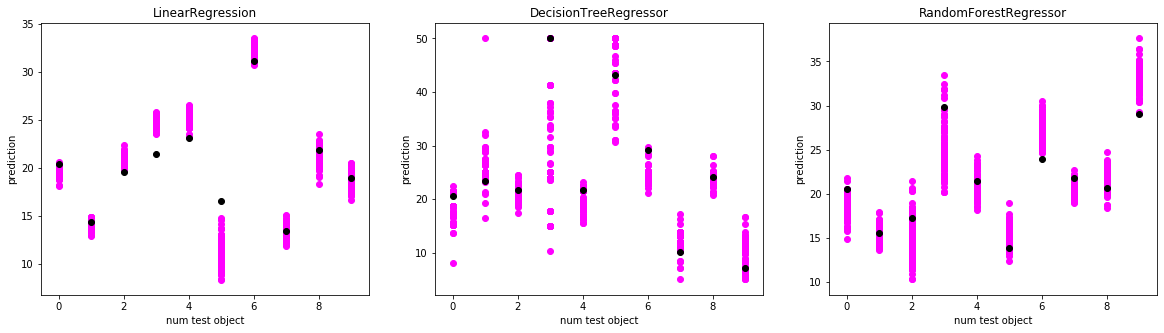

In [71]:
plt.figure(figsize=(20, 5))

regs = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

idx = 1
for reg in regs:
    plt.subplot(1, 3, idx)
    plot_predictions(reg, X, y, title=reg.__class__.__name__)
    idx += 1

__6. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ У лин. регрессии в основном очень большое смещение (черная точка далеко от середины розовой полоски), но относительно маленький разброс (длина розовой полоски). Для дерева смещение несильно большое, но существенно большой разброс во всех рассмотренных. У леса не сильно большое смещение относительно лин регресии и небольшой разброс относительно дерева. Графики согласутся с результатми выше.

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [74]:
max_features = np.arange(1, X.shape[1])
max_depths = np.arange(1, 10)

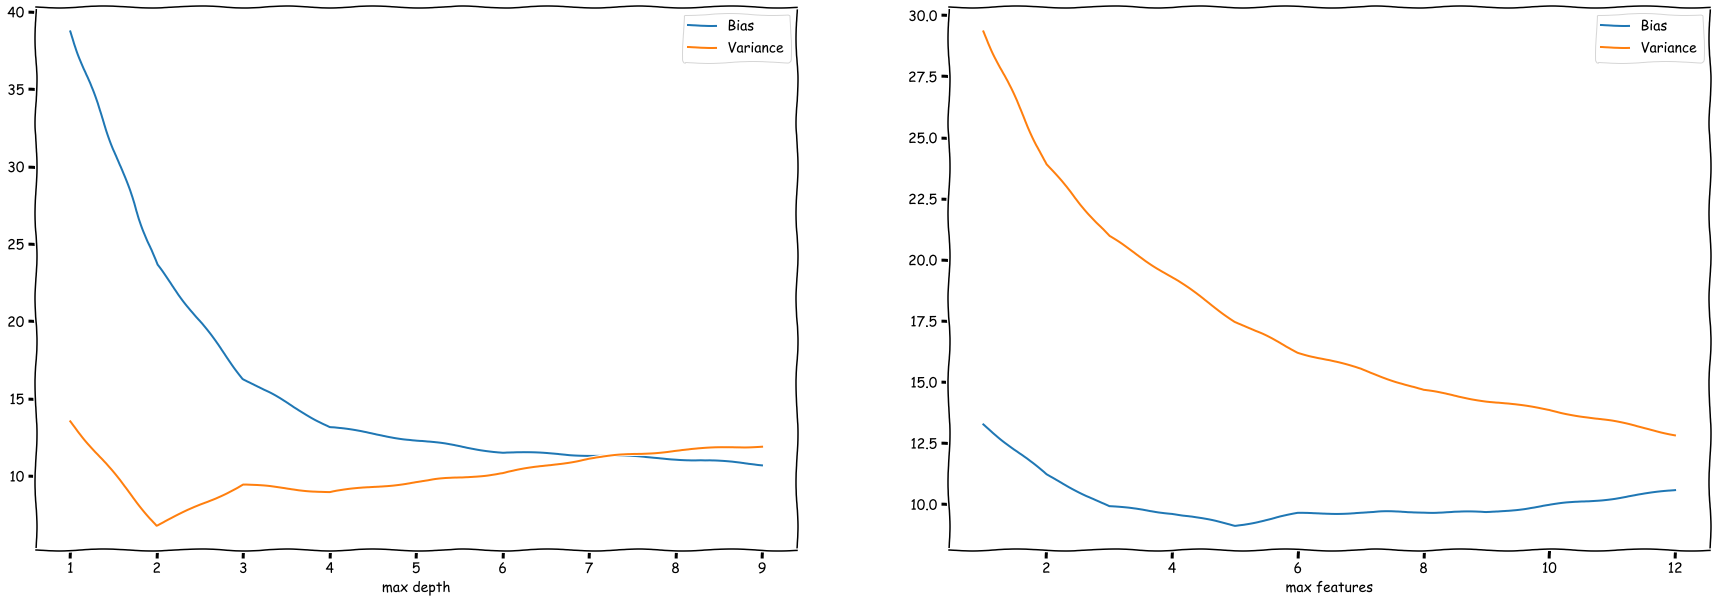

In [83]:
with plt.xkcd():
    plt.figure(figsize=(30, 10))

    biases = []
    variances = []
    
    for max_depth in max_depths:
        bias, var, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y) 
        biases.append(bias)
        variances.append(var)
        
    plt.subplot(1, 2, 1)
    plt.plot(max_depths, biases, label="Bias")
    plt.plot(max_depths, variances, label="Variance")
    plt.xlabel("max depth")
    plt.legend()
    
    biases = []
    variances = []
    
    for max_feature in max_features:
        bias, var, _ = compute_biase_variance(DecisionTreeRegressor(max_features=max_feature), X, y) 
        biases.append(bias)
        variances.append(var)
        
    plt.subplot(1, 2, 2)    
    plt.plot(max_features, biases, label="Bias")
    plt.plot(max_features, variances, label="Variance")
    plt.xlabel("max features")
    plt.legend()
    
    
    plt.show()

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

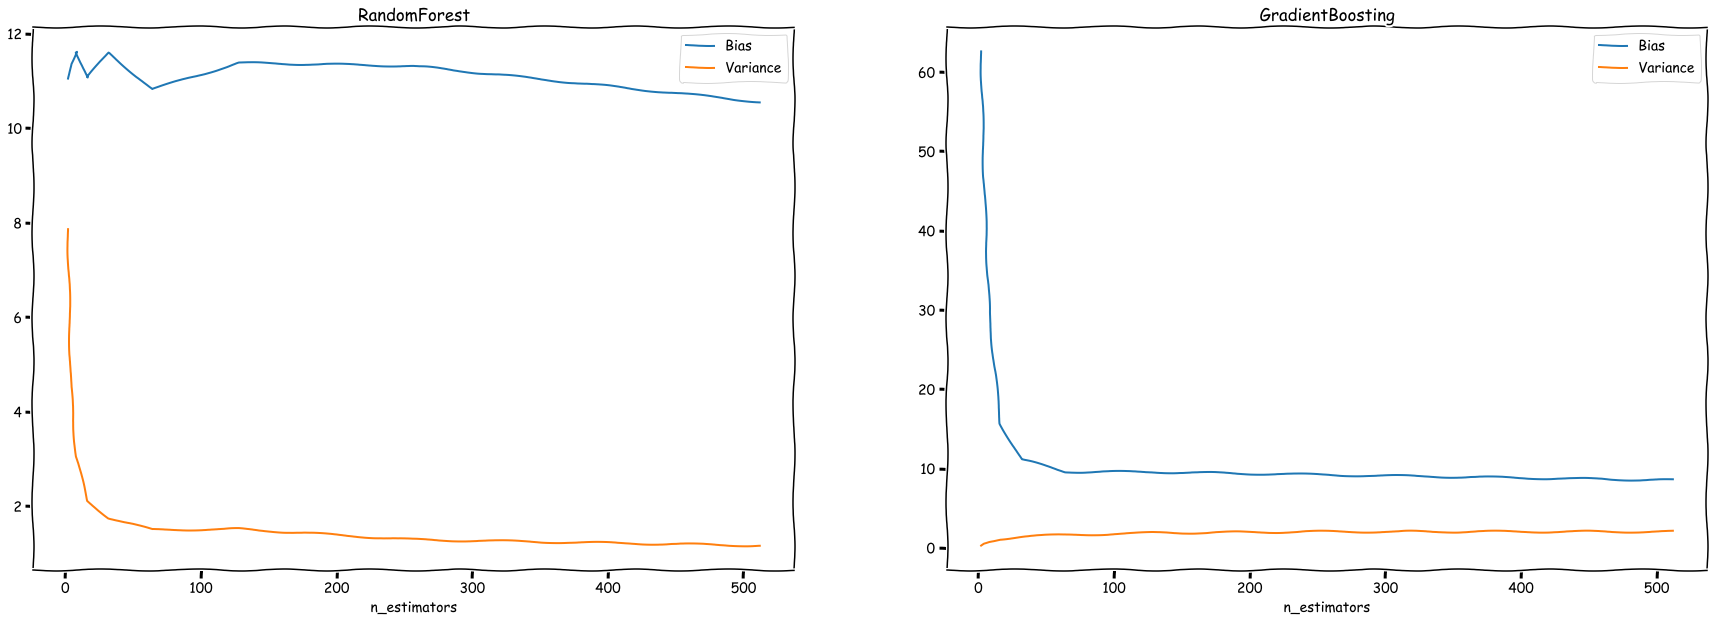

In [86]:
n_estimators = np.arange(1, 10)

with plt.xkcd():
    biases_f = []
    variances_f = []
    
    biases_b = []
    variances_b = []
    
    for n in n_estimators:
        bias, var, _ = compute_biase_variance(RandomForestRegressor(n_estimators=2**n), X, y, num_runs=40) 
        
        biases_f.append(bias)
        variances_f.append(var)
        
        bias, var, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=2**n), X, y, num_runs=40) 
        biases_b.append(bias)
        variances_b.append(var)
    
    plt.figure(figsize=(30, 10))
    
    plt.subplot(1, 2, 1)
    plt.plot(2 ** n_estimators, biases_f, label="Bias")
    plt.plot(2 ** n_estimators, variances_f, label="Variance")
    plt.xlabel("n_estimators")
    plt.legend()
    plt.title("RandomForest")
    
    
    plt.subplot(1, 2, 2)
    plt.plot(2 ** n_estimators, biases_b, label="Bias")
    plt.plot(2 ** n_estimators, variances_b, label="Variance")
    plt.xlabel("n_estimators")
    plt.legend()
    plt.title("GradientBoosting")
    
    plt.show()

__3. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 
* На первом графике видим, что при увеличении глубины увеличивается и разброс, что согласуется с чувствительностью деревьев к выборке, и уменьшается смещение, то есть мы лучше подстраиваемся под данные, что согласуется с нашими знаниями о деревьях
* С увеличением максимального количества признаков в вершине при той же глубине хуже подстараивается под данные (по сути, мы будем часто отвечать похоже в вершинах), на это указывает увеличение смещения, но при этом же уменьшается разброс, то есть мы становимся менее чувствительны к модификациям выборки.
* из графика видна основная цель использования леса: уменьшение разброса (следует из вывода формулы в лекции про бэггинг), мы обсуждали выше это выше
* Бустинг  -- враг бэггинга: он сильно уменьшает смещение, это связано с особенностью бустинга, а именно исправлением ошибок предыдущих деревьев при построении нового.
Стабилизация же последних обоих алгоритмов происходит из-за подстройки под шум и устранить данные ошибки мы вообще никак не можем.